# Example: 2D Koopman - Part 1/2

- Author: Dr. Daning Huang
- Date: 07/28/2025

## Introduction

In the previous 1D Oscillator example, we have covered the basic workflow in DyMAD:

- Generation of data
- Data transformation
- Configuration of model and trainer by YAML and/or dict
- Model training (KBF & LDM with NODE & WF)
- Result visualization

This example explores more features, such as using different autoencoder structures and concatenating two trainers.  In addition, here an autonomous system is considered, so that some options can be turned off for simplicity.

Specifically, this time we consider a classical example in Koopman theory,

$$
\begin{aligned}
\dot{x}_1 &= \mu x_1 \\
\dot{x}_2 &= \lambda (x_2-x_1^2)
\end{aligned}
$$
It is globally stable, and the origin is the equilibrium point.

An interesting fact is that it can be **exactly** converted to a linear system by introducing a third state $z_3=x_1^2$:

$$
\begin{aligned}
\dot{z}_1 &= \mu z_1 \\
\dot{z}_2 &= \lambda (z_2-z_3) \\
\dot{z}_3 &= 2\mu z_3
\end{aligned}
$$
where $z_1=x_1$ and $z_2=x_2$.

## Preparation

To start with, the imports:

In [18]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.models import KBF
from dymad.training import NODETrainer, WeakFormTrainer
from dymad.utils import load_model, plot_summary, plot_trajectory, setup_logging, TrajectorySampler

In [2]:
B = 256
N = 301
t_grid = np.linspace(0, 6, N)

mu = -0.5
lm = -3
def f(t, x):
    _d = np.array([mu*x[0], lm*(x[1]-x[0]**2)])
    return _d

The options for sampling are collected in `kp_data.yaml`, which by now should be self-explanatory.  Also, the options could be organized as a Python dict too.

In [ ]:
"""
dims:
  states: 2
  inputs: 0
  observations: 2

x0:
  kind: uniform
  params:
    bounds:
      - [-2.5, 2.5]
      - [-5.0, 5.0]

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

Then a two-liner for sampling.

In [3]:
sampler = TrajectorySampler(f, config='kp_data.yaml')
ts, xs, ys = sampler.sample(t_grid, batch=B, save='./data/kp.npz')

Plotting the trajectories.  One can note another feature of the dynamics, that there is a "slow manifold" (the parabolic line, $x_2-x_1^2=0$): starting from any point, the states quickly snap to the slow manifold, then slowly move towards the origin.

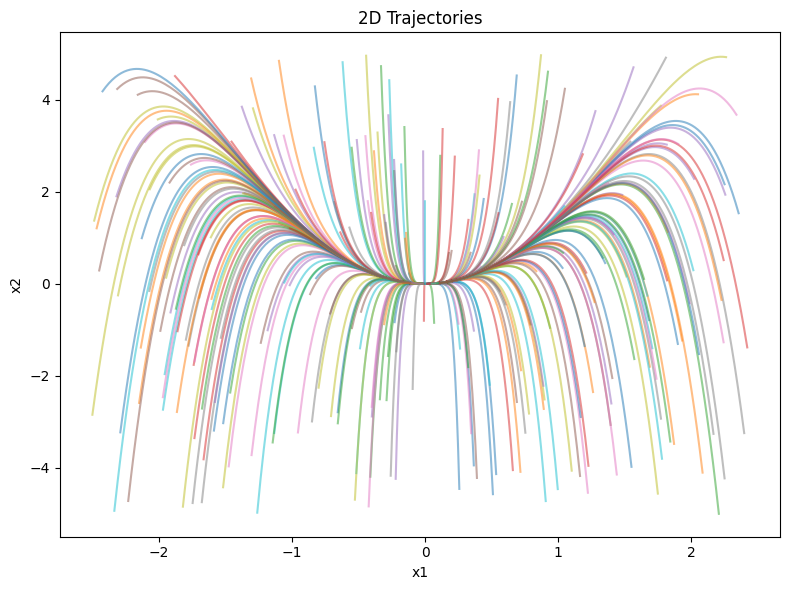

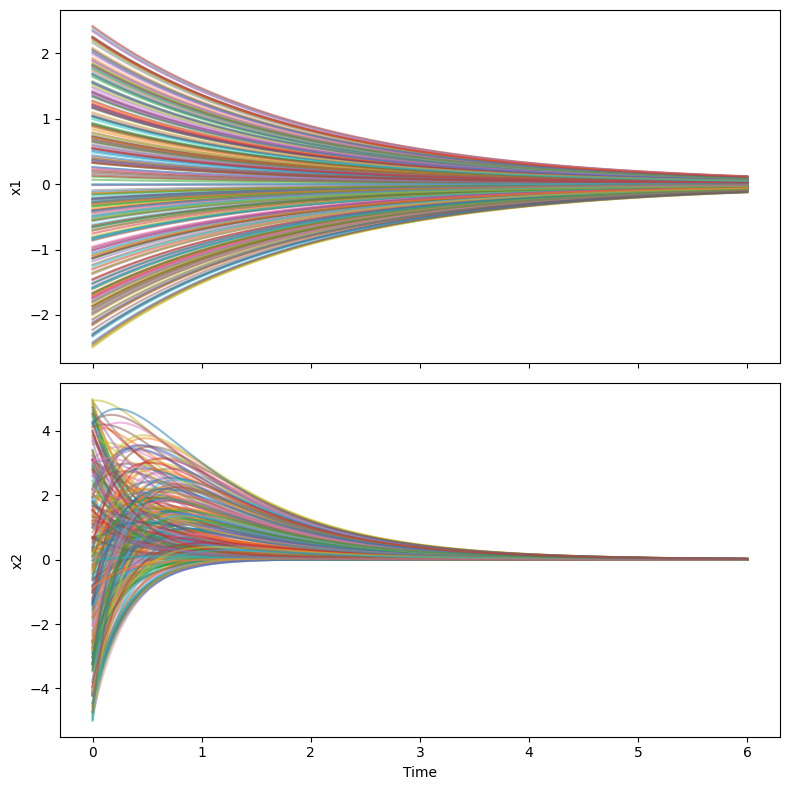

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in range(B):
    ax.plot(xs[i, :, 0], xs[i, :, 1], alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('2D Trajectories')
plt.tight_layout()

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for i in range(B):
    axs[0].plot(ts[i], xs[i, :, 0], alpha=0.5)
    axs[1].plot(ts[i], xs[i, :, 1], alpha=0.5)
axs[0].set_ylabel('x1')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('x2')
plt.tight_layout()

## Autoencoders

Previously, we used a generic autoencoder,
$$
z = f_{enc}(x),\quad x = f_{dec}(z)
$$
which typically requires an additional reconstruction loss during training:
$$
L_{recon} = \sum_i \|f_{dec}(f_{enc}(x_i)) - x_i\|^2
$$

Alternatively, we could use a concatenated structure,
$$
z = [x, \tilde{f}(x)] \equiv f_{enc}(x),\quad x = \text{TakeFirst}(z) \equiv f_{dec}(z)
$$
where the output of encoder contains $x$ and decoder simply takes the $x$ part as output.  The reconstruction loss is 0 by default, which would arguably accelerate the convergence and improve prediction accuracy.

> This is a typical technique, e.g., in Koopman learning, although there are limitations on the type of dynamics that it can handle.

### Baseline

Next, we first train a KBF model with generic autoencoder as a baseline.  To make things simple, we just consider the weak-form trainer.  By now you should be able to adapt this to the NODE trainer.

The common options, stored in `kp_model.yaml`:

In [ ]:
"""
data:
  path: './data/kp.npz'
  n_samples: 256
  n_steps: 301
  double_precision: true

transform_x:
  type: "scaler"
  mode: "std"

split:
  train_frac: 0.75

dataloader:
  batch_size: 256
"""

In [5]:
# Options for KBF, generic autoencoder, and weak form
mdl_kb = {
    "encoder_layers" : 2,
    "decoder_layers" : 2,
    "latent_dimension" : 32,
    "koopman_dimension" : 4,
    "activation" : "prelu",
    "weight_init" : "xavier_uniform"}
trn_wf = {
    "n_epochs": 1000,
    "save_interval": 50,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "reconstruction_weight": 1.0,
    "dynamics_weight": 1.0,
    "weak_form_params": {
        "N": 13,
        "dN": 2,
        "ordpol": 2,
        "ordint": 2}}
mdl_smp = {"name" : "kb_smp"}
mdl_smp.update(**mdl_kb)

config_path = 'kp_model.yaml'

Train the model.  We will compare results together with the other case.

In [6]:
setup_logging(config_path, mode='info', prefix='results')
logging.info(f"Config: {config_path}")
trainer = WeakFormTrainer(config_path, KBF, config_mod={"model":mdl_smp, "training":trn_wf})
trainer.train()

### Variation

Here comes the new autoencoder.  This only requires a minimal change: adding an entry `autoencoder_type`.  Here `cat` points to a predefined autoencoder, that is identity mapping concatenated with a standard MLP.

In [10]:
mdl_cat = {
    "name" : "kb_cat",
    "autoencoder_type" : "cat"}   # New entry
mdl_cat.update(**mdl_kb)

In [11]:
setup_logging(config_path, mode='info', prefix='results')
logging.info(f"Config: {config_path}")
trainer = WeakFormTrainer(config_path, KBF, config_mod={"model":mdl_cat, "training":trn_wf})
trainer.train()

### Comparison

Like before, we show two comparisons: convergence history, and prediction on test.

First the convergence.  Both results are weak-form, so the losses are comparable.  Using the same number of epochs, `cat` ends up with one-order-of-magnitude lower than `smp`.  The lower loss in `cat` also brings better trajectory error.

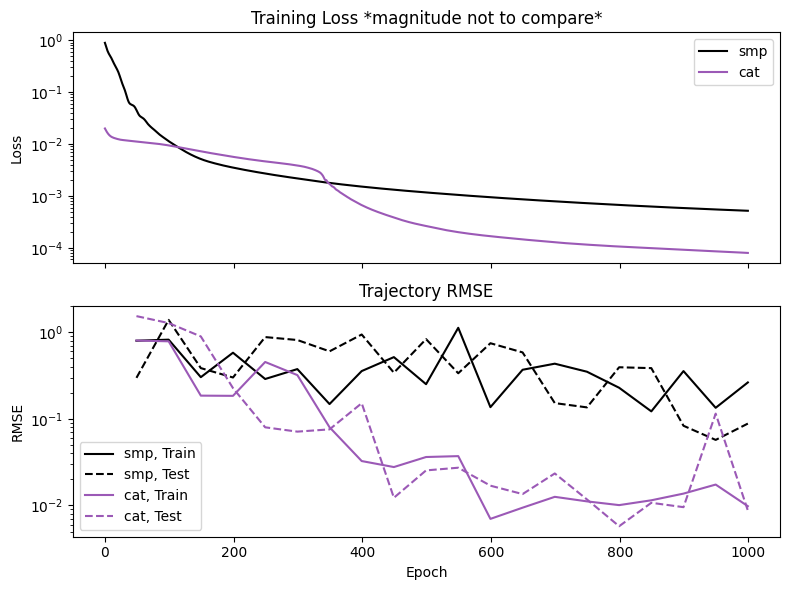

In [13]:
labels = ['smp', 'cat']
npz_files = [f'results/kb_{l}_summary.npz' for l in labels]
npzs = plot_summary(npz_files, labels=labels, ifscl=False, ifclose=False)

Next, the predictions on a random new trajectory are compared.  Clearly, `cat` beats the generic autoencoder `smp`.

> In the context of Koopman learning, `cat` is effective for systems with a fixed point, but might not be for others.

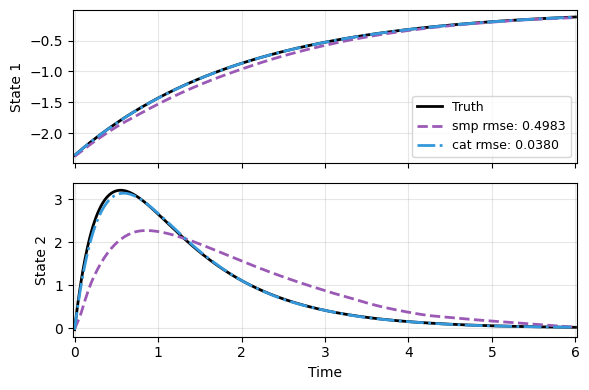

In [ ]:
ts, xs, ys = sampler.sample(t_grid, batch=1)
x_data = xs[0]
t_data = ts[0]

# The generic case
_, prd_func = load_model(KBF, f'kb_smp.pt', f'kp_model.yaml', config_mod={"model":mdl_smp, "training":trn_wf})
with torch.no_grad():
    pred_smp = prd_func(x_data, t_data)

# The variation
_, prd_func = load_model(KBF, f'kb_cat.pt', f'kp_model.yaml', config_mod={"model":mdl_cat, "training":trn_wf})
with torch.no_grad():
    pred_cat = prd_func(x_data, t_data)

# Compare
res = [x_data, pred_smp, pred_cat]
plot_trajectory(
    np.array(res), t_data, "KP",
    labels=['Truth'] + labels, ifclose=False)

## Sequential Training

Next, we explore the feature of restarting: first train a model by weak-form for some epochs, then restart the training with NODE.

The general intuition is that weak-form is fast to train but might not produce highly-accurate models, but NODE is the opposite given a good initial guess.  So concatenating the two can be beneficial.

To do so, we will consider 3 cases for KBF with generic autoencoder:

- Weak form for 1000 epochs
- NODE for 1000 epochs
- Weak form for 500 epochs, then NODE for 500 epochs

### Baseline

We have already done the weak-form case.  Next let's complete the NODE case.

In [19]:
mdl_nd = {"name" : "kb_nd"}  # Rename to create a different model
mdl_nd.update(**mdl_kb)

trn_nd = {
    "n_epochs": 1000,
    "save_interval": 20,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "reconstruction_weight": 1.0,
    "dynamics_weight": 1.0,
    "sweep_lengths": [30, 50, 100, 200, 301],
    "sweep_epoch_step": 200,
    "ode_method": "dopri5",
    "rtol": 1e-7,
    "atol": 1e-9
}

In [20]:
setup_logging(config_path, mode='info', prefix='results')
logging.info(f"Config: {config_path}")
trainer = NODETrainer(config_path, KBF, config_mod={"model":mdl_nd, "training":trn_nd})
trainer.train()

### Sequential Case

We first modify the options.  The first training step is easy, we just reduce the number of epochs.  The second one has one more modification: specify the previous checkpoint to load to restart the optimization.

In [21]:
mdl_seq = {"name" : "kb_seq"}  # Rename to create a different model
mdl_seq.update(**mdl_kb)

trn_wf_seq = {}
trn_wf_seq.update(**trn_wf)
trn_wf_seq.update(n_epochs=500)

trn_nd_seq = {}
trn_nd_seq.update(**trn_nd)
trn_nd_seq.update(
    n_epochs=500,
    load_checkpoint="./checkpoints/kb_seq_checkpoint.pt",
    sweep_epoch_step=100
)

After this, we do two consecutive training sessions.

In [22]:
setup_logging(config_path, mode='info', prefix='results')
logging.info(f"Config: {config_path}")
trainer = WeakFormTrainer(config_path, KBF, config_mod={"model":mdl_seq, "training":trn_wf_seq})
trainer.train()

In [23]:
setup_logging(config_path, mode='info', prefix='results')
logging.info(f"Config: {config_path}")
trainer = NODETrainer(config_path, KBF, config_mod={"model":mdl_seq, "training":trn_nd_seq})
trainer.train()

### Comparison

First, the convergence plot.  The interpretation of the results should be careful.

- The first segment of `seq` is comparable to `smp`, as both are weak-form, and the two do share a similar trend.
- The second segment of `seq` is comparable to `nd`, for NODE.  Clearly, given a better initial guess, `seq` starts at a lower loss, and the loss drops much faster than `nd`.

Epoch time wf/nd: 0.0564084845213628
Epoch time seq/nd: 1.2420692193801093


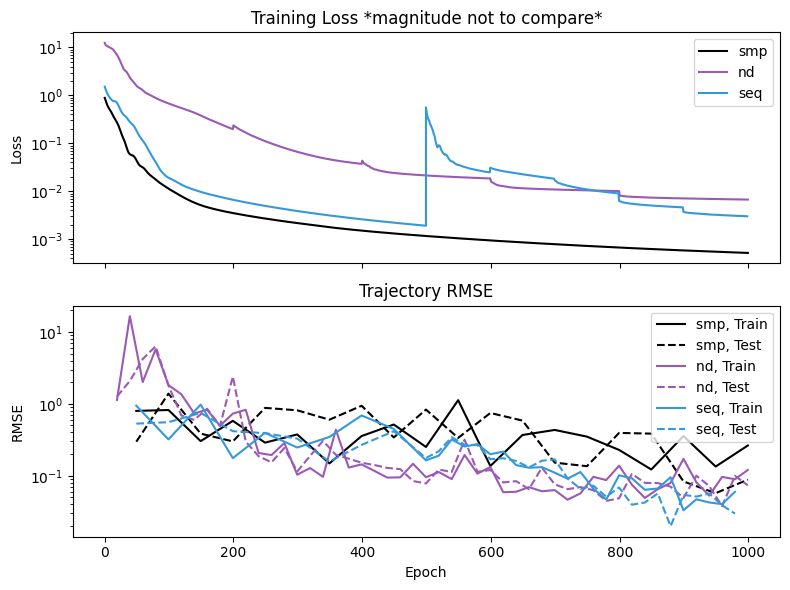

In [24]:
labels = ['smp', 'nd', 'seq']
npz_files = [f'results/kb_{l}_summary.npz' for l in labels]
npzs = plot_summary(npz_files, labels=labels, ifscl=False, ifclose=False)

print(f"Epoch time wf/nd: {npzs[0]['avg_epoch_time']/npzs[1]['avg_epoch_time']}")
print(f"Epoch time seq/nd: {npzs[2]['avg_epoch_time']/npzs[1]['avg_epoch_time']}")

Second, the prediction on test.  We recycle the earlier results of `smp`.  `nd` does improve on `smp`.  But with a bit more cost, `seq` further improves on `nd`.

> But all of them are worse than `cat`, highlighting the importance of using the correct structure for learning dynamics.

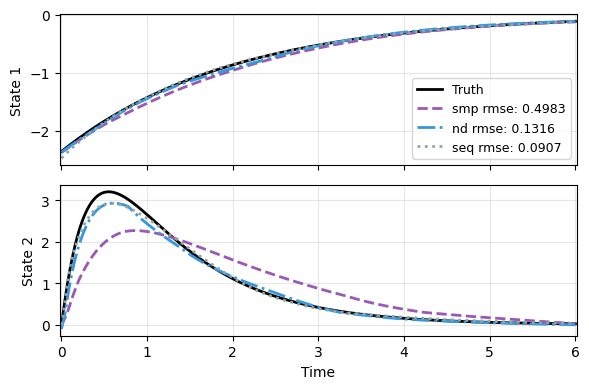

In [ ]:
# NODE
_, prd_func = load_model(KBF, f'kb_nd.pt', f'kp_model.yaml', config_mod={"model":mdl_nd, "training":trn_nd})
with torch.no_grad():
    pred_nd = prd_func(x_data, t_data)

# Sequential
_, prd_func = load_model(KBF, f'kb_seq.pt', f'kp_model.yaml', config_mod={"model":mdl_seq, "training":trn_nd_seq})
with torch.no_grad():
    pred_seq = prd_func(x_data, t_data)

# Compare
res = [x_data, pred_smp, pred_nd, pred_seq]
plot_trajectory(
    np.array(res), t_data, "KP",
    labels=['Truth'] + labels, ifclose=False)